#  __Sentiment Analysis On IMDB Reviews__

IMDb is an online database of information about films, television programs, games and streaming content online which includes cast, production crew and divas, ratings, fan and critics reviews.

__Data Source__ : http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

#### Objective:

In this project we are going to do the analysis of IMDb (Internet Movie Database) reviewsby comparing it with two models i.e., Lexicon rule based analysis model and comparing with XG Boost.


In [1]:
#installing all libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing,tree
from prettytable import PrettyTable
from google.colab import drive


In [ ]:
drive.mount('/content/driver/')

In [2]:
with open('/content/driver/My Drive/data.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
df[:10]

,review,label
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1
5,"This isn't the comedic Robin Williams, nor is ...",1
6,Yes its an art... to successfully make a slow ...,1
7,"In this ""critically acclaimed psychological th...",1
8,THE NIGHT LISTENER (2006) **1/2 Robin Williams...,1
9,"You know, Robin Williams, God bless him, is co...",1


## Data Preprocessing

In [4]:
# find sentences containing HTML tags
import re
i=0;
for sent in df.review.values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

1
Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school, work, or vote for the matter. Most people think of the homeless as just a lost cause while worrying about things such as racism, the war on Iraq, pressuring kids to succeed, technology, the elections, inflation, or worrying if they'll be next to end up on the streets.<br /><br />But what if you were given a bet to live on the streets for a month without the luxuries you once had from a home, the entertainment sets, a bathroom, pictures on the wall, a computer, and everything you once treasure to see what it's like to be homeless? That is Goddard Bolt's lesson.<br /><br />Mel Brooks (who directs) who stars as Bolt plays a rich man who has everything in the world until deciding to make a bet with a sissy rival (Jeffery Tambor) to see if he can live in the streets for thirty days without 

In [5]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
#print(stop)
#print('************************************')
#print(sno.stem('Homelessness'))


In [6]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [7]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in tqdm(df.review.values):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent)# remove HTMl tags
    sent = decontracted(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")

    final_string.append(str1)
    i+=1

df["clean_review"] = final_string
df['clean_review']=df['clean_review'].str.decode("utf-8")

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:43<00:00, 223.80it/s]


In [12]:
#pickle_out = open("clean_data.pickle","wb")
#pickle.dump(df, pickle_out)
#pickle_out.close()

In [8]:
df[:10]

,review,label,clean_review
0,Bromwell High is a cartoon comedy. It ran at t...,1,bromwel high cartoon comedi ran time program s...
1,Homelessness (or Houselessness as George Carli...,1,homeless houseless georg carlin state issu yea...
2,Brilliant over-acting by Lesley Ann Warren. Be...,1,brilliant lesley ann warren best dramat hobo l...
3,This is easily the most underrated film inn th...,1,easili underr film inn brook cannon sure flaw ...
4,This is not the typical Mel Brooks film. It wa...,1,typic mel brook film much less slapstick movi ...
5,"This isn't the comedic Robin Williams, nor is ...",1,comed robin william quirki insan robin william...
6,Yes its an art... to successfully make a slow ...,1,yes art success make slow pace thriller stori ...
7,"In this ""critically acclaimed psychological th...",1,critic acclaim psycholog thriller base true ev...
8,THE NIGHT LISTENER (2006) **1/2 Robin Williams...,1,night listen robin william toni collett bobbi ...
9,"You know, Robin Williams, God bless him, is co...",1,know robin william god bless constant shoot fo...


## Featurization

In [9]:
df_train = df[:30000]
df_test = df[30000:]
Y_train = df_train["label"].values
Y_test = df_test["label"].values

### BOW
The bag-of-words model is a simplifying representation used in natural language processing and information retrieval. In this model, a text is represented as the bag of its words, disregarding grammar and even word order

In [10]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(df_train.clean_review.values)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

BOW_train = count_vect.transform(df_train.clean_review.values)
BOW_test = count_vect.transform(df_test.clean_review.values)
print("the type of count vectorizer ",type(BOW_train))
print("the shape of out text BOW vectorizer ",BOW_train.get_shape())
print("the shape of out text BOW vectorizer ",BOW_test.get_shape())
print("the number of unique words ", BOW_train.get_shape()[1])

some feature names  ['aaa', 'aaaaaaah', 'aaaaagh', 'aaaaah', 'aaaahhhhhhh', 'aaaand', 'aaaarrgh', 'aaah', 'aaargh', 'aaaugh']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (30000, 51245)
the shape of out text BOW vectorizer  (20000, 51245)
the number of unique words  51245


### TF-IDF
In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

In [18]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,1)) 
tf_idf_vect.fit(df_train.clean_review.values)
tf_idf_train = tf_idf_vect.transform(df_train.clean_review.values)
tf_idf_test = tf_idf_vect.transform(df_test.clean_review.values)
print(tf_idf_train.get_shape())
print(tf_idf_test.get_shape())

(30000, 51245)
(20000, 51245)


### AVG W2V
__Word2vec__ is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words. Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located close to one another in the space. for average W2V we take mean of all word vectors presen in a sentence.

In [148]:
# Loading Pre trained W2V model with 50 Dimensions
pkl = open('/content/driver/My Drive/w2v_50.pickle','rb') 
w2v_ = pickle.load(pkl)
pkl.close()

In [135]:
w2v_["great"]

array([ 0.89191914,  2.0758767 ,  0.26216456,  0.9528575 ,  0.43434745,
        0.6346482 , -1.2172489 ,  2.1998944 , -1.5962636 ,  0.53259933,
        0.06251495,  1.2159452 , -0.27255023, -0.58379555, -1.8364413 ,
        0.7035821 , -2.471225  ,  1.4570612 ,  2.5785868 , -0.57135475,
        1.3771918 ,  0.82174754, -3.1399    , -1.1322075 ,  0.32333642,
       -1.0728499 ,  1.748775  , -0.4199878 ,  0.15866372, -1.5732543 ,
       -0.5313495 ,  0.22907357,  0.61730766, -1.1254811 , -2.6159725 ,
        0.6311149 , -0.8404826 , -0.7743713 ,  1.6430057 , -1.6226189 ,
       -2.2037477 ,  0.36655995,  0.13461213,  0.5559572 ,  0.32933322,
       -0.03422351,  2.1431437 ,  0.7282826 , -1.9529035 ,  1.2801542 ],
      dtype=float32)

In [149]:
# average Word2Vec for Train dataset

# creating a list of list of words present in each sentence
i=0
list_of_sent=[]
for sent in df_train.clean_review.values:
    list_of_sent.append(sent.split())
    
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_:
            vec = w2v_.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

AVG_W2V_train = sent_vectors


100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [00:39<00:00, 759.85it/s]


30000
50


In [151]:
# saving avgW2V vectors for train data set
#pickle_out = open("avg_w2v_train.pickle","wb")
#pickle.dump(sent_vectors, pickle_out)
#pickle_out.close()

In [152]:
# average Word2Vec for test dataset

# creating a list of list of words present in each sentence
i=0
list_of_sent=[]
for sent in df_test.clean_review.values:
    list_of_sent.append(sent.split())
    
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_:
            vec = w2v_.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

AVG_W2V_test = sent_vectors



100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:26<00:00, 754.92it/s]


20000
50


In [155]:
# saving avgW2V vectors for train data set
#pickle_out = open("avg_w2v_test.pickle","wb")
#pickle.dump(sent_vectors, pickle_out)
#pickle_out.close()

### Tf-IDF  WEIGHTED W2V
we will calculate tfidf value of each word. than follow the same approach as above section by multiplying tfidf value with the corresponding word and then divided the sum by sum tfidf value.

In [156]:
#tfidf w2v
model = TfidfVectorizer()
model.fit(df_train.clean_review.values)
tf_idf_matrix = model.transform(df_train.clean_review.values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [157]:
#for train data set

# creating a list of list of words present in each sentence
i=0
list_of_sent=[]
for sent in df_train.clean_review.values:
    list_of_sent.append(sent.split())
    
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_:
            if word in dictionary:
                vec = w2v_.wv[word]
                # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))

TF_W2V_train = tfidf_sent_vectors

   

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:27<00:00, 343.61it/s]


30000
50


In [158]:
# saving the vectors for future use
#with open('tf_w2v_train.pkl','wb') as f:
#    pickle.dump(tfidf_sent_vectors,f) 

In [159]:
#for test data set

# creating a list of list of words present in each sentence
i=0
list_of_sent=[]
for sent in df_test.clean_review.values:
    list_of_sent.append(sent.split())
    
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_:
            if word in dictionary:
                vec = w2v_.wv[word]
                # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    

print(len(tfidf_sent_vectors))
print(len(tfidf_sent_vectors[0]))

TF_W2V_test = tfidf_sent_vectors

    

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:50<00:00, 397.79it/s]


20000
50


In [160]:
# saving the vectors for future use
#with open('tf_w2v_test.pkl','wb') as f:
#    pickle.dump(tfidf_sent_vectors,f)

# Models

## Lexicon rule based analysis model

In [83]:
X_train = df_train.clean_review.values
X_test = df_test.clean_review.values

In [10]:
all_words = count_vect.get_feature_names()

In [12]:
#Lexicon Generation --> wordScore = #Positive sentences/(#Positive sentences + #Negative sentences)
vocab=dict()
j = 0
for w in tqdm(all_words):
    i=0
    p_count=0
    n_count=0
    for sent in X_train:
        #print(w)
        if w in str(sent):
            #print(w)
            if df_train["label"][i] == 1:
                p_count = p_count + 1
                #print(p_count)
            else:
                n_count = n_count + 1
                #print(n_count)
        i=i+1
        
    if (p_count + n_count) != 0:
        p_factor = (p_count/(p_count + n_count))
        n_factor = (n_count/(p_count + n_count))
        vocab[w] =[p_factor,n_factor]
        

100%|██████████████████████████████████████████████████████████████████████████| 60115/60115 [2:38:52<00:00,  6.64it/s]


In [97]:
print("wonder = ",vocab["wonder"])
print("great = ",vocab["great"])
print("bad = ",vocab["bad"])

wonder =  [0.6150963597430407, 0.38490364025695933]
great =  [0.6660612664971546, 0.33393873350284536]
bad =  [0.25382466409471865, 0.7461753359052814]


In [40]:
#"""with open('vocab.pkl', 'wb') as f:
#    pickle.dump(vocab, f)"""

In [91]:
def predict_lrm(test_x_):
    #this function give class and score for each class
    y =[]
    conf = []
    for sent in list(test_x_):
        p_l= 0
        n_l=0
        for w in str(sent).split():
            if w in vocab:
                p_l = p_l + vocab[w][0]
                n_l = n_l + vocab[w][1]
        if p_l > n_l:
            y.append(1)
        else:
            y.append(0)
        conf.append([p_l,n_l])
    return y,conf       

In [93]:
pred,conf = predict_lrm(X_test)
#ROC_AUC_SCORE:
roc = sklearn.metrics.roc_auc_score(Y_test,pred)
print("ROC_AUC_SCORE = ",roc )

ROC_AUC_SCORE =  0.8541


In [ ]:
plt.figure()
lw = 2


#test
print('For Test\n')
pred,conf = predict_lrm(X_test)

#ROC_AUC_SCORE:
roc = sklearn.metrics.roc_auc_score(Y_test,pred)
print("ROC_AUC_SCORE = ",roc )

#confusion_matrix
CM = confusion_matrix(Y_test, pred)
A = ['TN','FP','FN','TP']
B= CM.ravel()
for i in range (0,4):
    A[i] = '%s = %d' %(A[i],B[i])
A =np.array(A).reshape((2,2))
print("\n",CM)
heatmap(CM,cmap="Blues",linewidths=.5,annot = A,fmt ='s',yticklabels=['Actual:NO','Actual:YES'],xticklabels=['Predicted:NO','Predicted:YES'])
plt.show()

#train
print("="*50)
print('\nFor Train')
pred,conf = predict_lrm(X_train)

#ROC_AUC_SCORE:
roc = sklearn.metrics.roc_auc_score(Y_train,pred)
print("\nROC_AUC_SCORE = ",roc )

#confusion_matrix
CM = confusion_matrix(Y_train, pred)
A = ['TN','FP','FN','TP']
B= CM.ravel()
for i in range (0,4):
    A[i] = '%s = %d' %(A[i],B[i])
A =np.array(A).reshape((2,2))
print("\n",CM)
heatmap(CM,cmap="Blues",linewidths=.5,annot = A,fmt ='s',yticklabels=['Actual:NO','Actual:YES'],xticklabels=['Predicted:NO','Predicted:YES'])
plt.show()

#ROC_AUC_SCORE:
roc = sklearn.metrics.roc_auc_score(y_true,preicted_y)

## XGBOOST

### BOW

In [48]:
X_train = preprocessing.maxabs_scale(BOW_train)
X_test = preprocessing.maxabs_scale(BOW_test)

In [50]:
now = datetime.now()
tuned_parameters = [{'max_depth': [1,2,3],'n_estimators':[20,50,75,100]}] #values of hyperparameter for tunning
clf = xgb.XGBClassifier() #define classifier
model = GridSearchCV(clf, tuned_parameters, scoring = 'roc_auc', cv=3, return_train_score=True) #cross validation
model.fit(X_train, Y_train)

print(model.best_estimator_)
print(model.score(X_test, Y_test))
#results =model.cv_results_

bow_model = model
print(datetime.now()-now)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
0.8989029799999999
0:09:29.003755


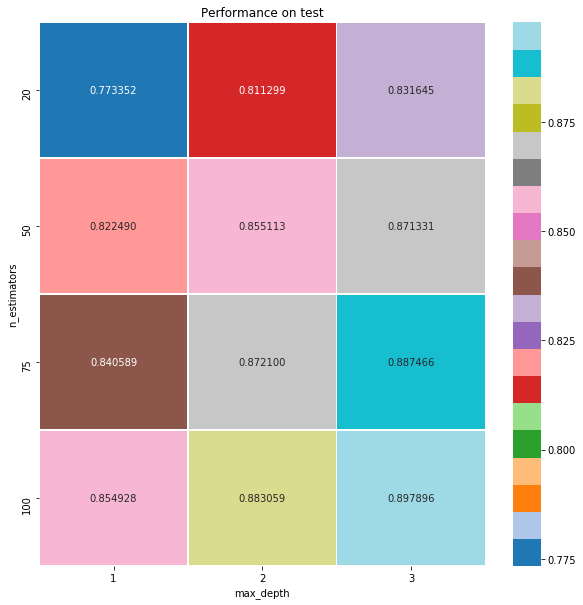

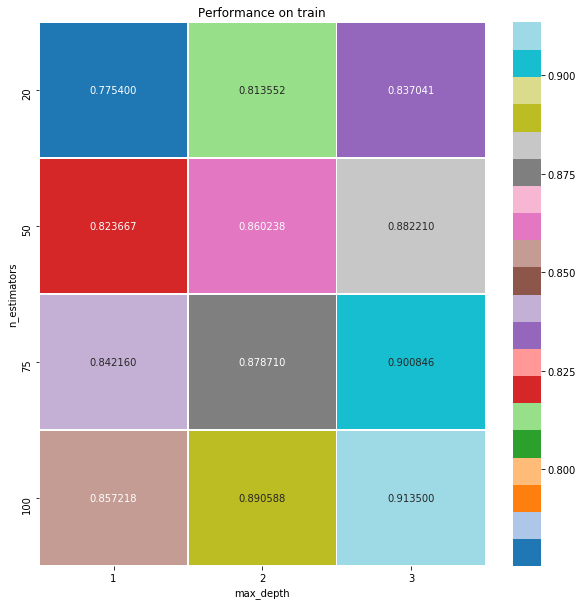

In [51]:
AUC_train = model.cv_results_['mean_train_score'].reshape((3,4)).T
AUC_test = model.cv_results_['mean_test_score'].reshape((3,4)).T
plt.figure(figsize=(10,10))
heatmap(AUC_test,cmap="tab20",linewidths=.5,annot = AUC_test,fmt ='f',xticklabels=[1,2,3],yticklabels=[20,50,75,100])
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.title("Performance on test")
plt.show()
plt.figure(figsize=(10,10))
heatmap(AUC_train,cmap="tab20",linewidths=.5,annot = AUC_train,fmt ='f',xticklabels=[1,2,3],yticklabels=[20,50,75,100])
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.title("Performance on train")
plt.show()

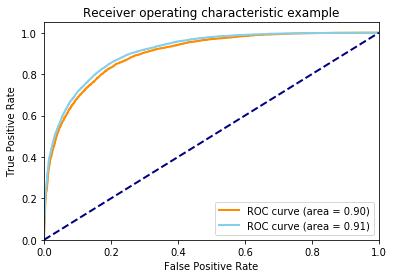

For Test
[[7568 2432]
 [1328 8672]]


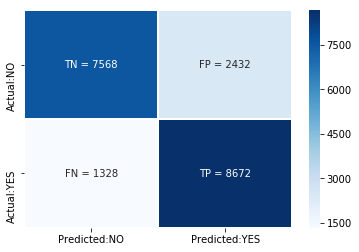

For Train
[[11495  3505]
 [ 1777 13223]]


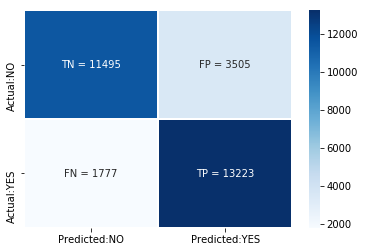

In [52]:
plt.figure()
lw = 2

#ROC_AUC curve
# plot for test

prob = model.predict_proba(X_test)
pred = []
for i in range (0,X_test.shape[0]):
    pred.append(prob[i][1]) 
fpr, tpr, thresholds = roc_curve(Y_test,pred)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

#plot for train

prob = model.predict_proba(X_train)
pred = []
for i in range (0,X_train.shape[0]):
    pred.append(prob[i][1]) 
fpr, tpr, thresholds = roc_curve(Y_train,pred)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='skyblue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
print('='*50)

#confusion_matrix
#test
print('For Test')
pred = model.predict(X_test)
CM = confusion_matrix(Y_test, pred)
A = ['TN','FP','FN','TP']
B= CM.ravel()
for i in range (0,4):
    A[i] = '%s = %d' %(A[i],B[i])
A =np.array(A).reshape((2,2))
print(CM)
heatmap(CM,cmap="Blues",linewidths=.5,annot = A,fmt ='s',yticklabels=['Actual:NO','Actual:YES'],xticklabels=['Predicted:NO','Predicted:YES'])
plt.show()
#train
print('For Train')
pred = model.predict(X_train)
CM = confusion_matrix(Y_train, pred)
A = ['TN','FP','FN','TP']
B= CM.ravel()
for i in range (0,4):
    A[i] = '%s = %d' %(A[i],B[i])
A =np.array(A).reshape((2,2))
print(CM)
heatmap(CM,cmap="Blues",linewidths=.5,annot = A,fmt ='s',yticklabels=['Actual:NO','Actual:YES'],xticklabels=['Predicted:NO','Predicted:YES'])
plt.show()

### TF-IDF

In [19]:
X_train = preprocessing.maxabs_scale(tf_idf_train)
X_test = preprocessing.maxabs_scale(tf_idf_test)

In [21]:
now = datetime.now()
tuned_parameters = [{'max_depth': [1,2,3],'n_estimators':[20,50,75,100]}] #values of hyperparameter for tunning
clf = xgb.XGBClassifier() #define classifier
model = GridSearchCV(clf, tuned_parameters, scoring = 'roc_auc', cv=3, return_train_score=True) #cross validation
model.fit(X_train, Y_train)

print(model.best_estimator_)
print(model.score(X_test, Y_test))
#results =model.cv_results_

tfidf_model = model

bow_model = model
print(datetime.now()-now)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
0.899354105
0:15:32.962474


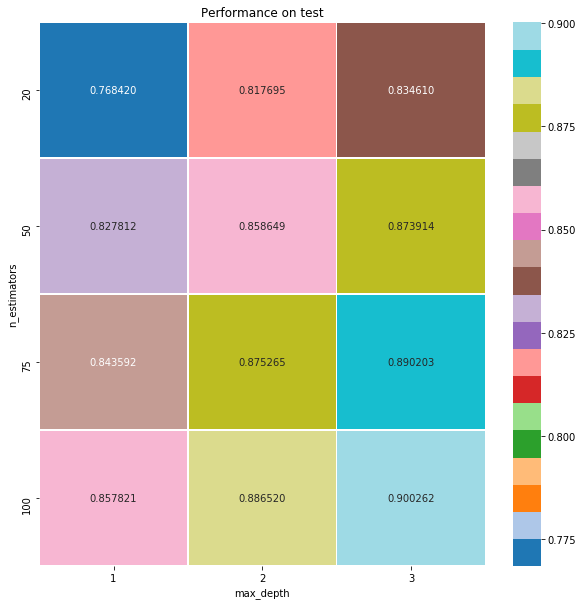

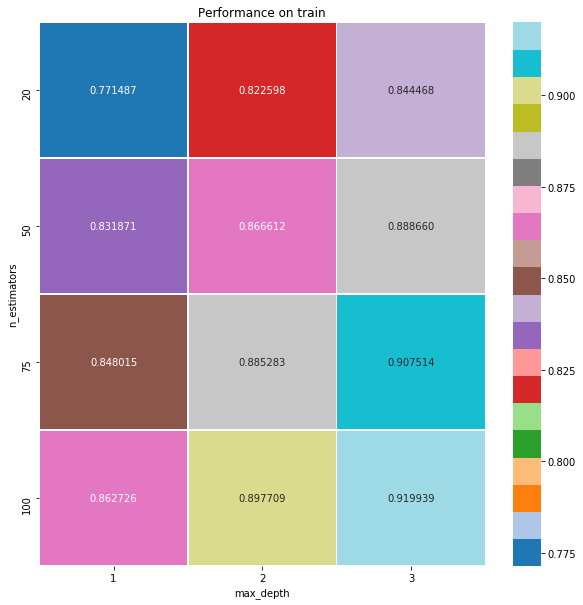

In [22]:
AUC_train = model.cv_results_['mean_train_score'].reshape((3,4)).T
AUC_test = model.cv_results_['mean_test_score'].reshape((3,4)).T
plt.figure(figsize=(10,10))
heatmap(AUC_test,cmap="tab20",linewidths=.5,annot = AUC_test,fmt ='f',xticklabels=[1,2,3],yticklabels=[20,50,75,100])
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.title("Performance on test")
plt.show()
plt.figure(figsize=(10,10))
heatmap(AUC_train,cmap="tab20",linewidths=.5,annot = AUC_train,fmt ='f',xticklabels=[1,2,3],yticklabels=[20,50,75,100])
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.title("Performance on train")
plt.show()

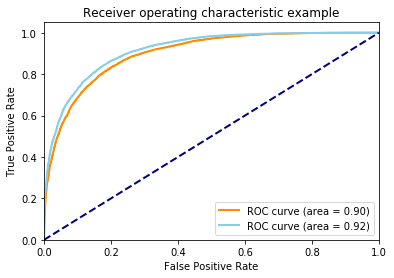

For Test
[[7654 2346]
 [1359 8641]]


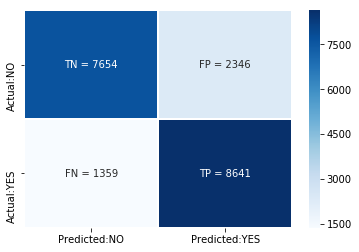

For Train
[[11587  3413]
 [ 1726 13274]]


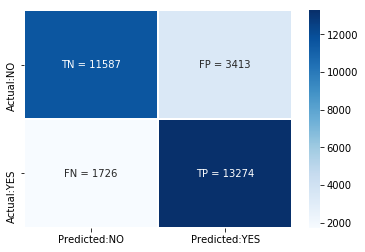

In [23]:
plt.figure()
lw = 2

#ROC_AUC curve
# plot for test

prob = model.predict_proba(X_test)
pred = []
for i in range (0,X_test.shape[0]):
    pred.append(prob[i][1]) 
fpr, tpr, thresholds = roc_curve(Y_test,pred)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

#plot for train

prob = model.predict_proba(X_train)
pred = []
for i in range (0,X_train.shape[0]):
    pred.append(prob[i][1]) 
fpr, tpr, thresholds = roc_curve(Y_train,pred)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='skyblue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
print('='*50)

#confusion_matrix
#test
print('For Test')
pred = model.predict(X_test)
CM = confusion_matrix(Y_test, pred)
A = ['TN','FP','FN','TP']
B= CM.ravel()
for i in range (0,4):
    A[i] = '%s = %d' %(A[i],B[i])
A =np.array(A).reshape((2,2))
print(CM)
heatmap(CM,cmap="Blues",linewidths=.5,annot = A,fmt ='s',yticklabels=['Actual:NO','Actual:YES'],xticklabels=['Predicted:NO','Predicted:YES'])
plt.show()
#train
print('For Train')
pred = model.predict(X_train)
CM = confusion_matrix(Y_train, pred)
A = ['TN','FP','FN','TP']
B= CM.ravel()
for i in range (0,4):
    A[i] = '%s = %d' %(A[i],B[i])
A =np.array(A).reshape((2,2))
print(CM)
heatmap(CM,cmap="Blues",linewidths=.5,annot = A,fmt ='s',yticklabels=['Actual:NO','Actual:YES'],xticklabels=['Predicted:NO','Predicted:YES'])
plt.show()

### AVG W2V

In [35]:
#pkl = open('/content/driver/My Drive/avg_w2v_train.pickle','rb') 
#AVG_W2V_train = pickle.load(pkl)
#pkl.close()

#pkl = open('/content/driver/My Drive/avg_w2v_test.pickle','rb') 
#AVG_W2V_test = pickle.load(pkl)
#pkl.close()

In [36]:
scaler = preprocessing.StandardScaler().fit(AVG_W2V_train)
X_train = scaler.transform(AVG_W2V_train)
X_test = scaler.transform(AVG_W2V_test)

In [37]:
now = datetime.now()
tuned_parameters = [{'max_depth': [1,2,3],'n_estimators':[20,50,75,100]}] #values of hyperparameter for tunning
clf = xgb.XGBClassifier() #define classifier
model = GridSearchCV(clf, tuned_parameters, scoring = 'roc_auc', cv=3, return_train_score=True) #cross validation
model.fit(X_train, Y_train)

print(model.best_estimator_)
print(model.score(X_test, Y_test))
results =model.cv_results_

avw2v_model = model
print(datetime.now() - now)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
0.858778705
0:04:02.681997


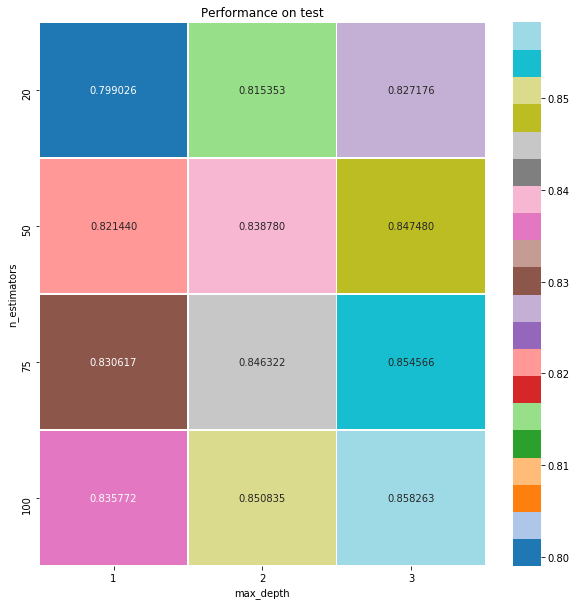

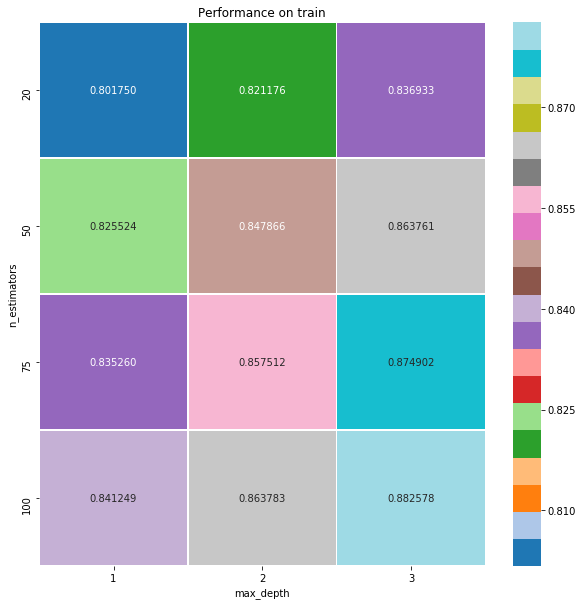

In [38]:
AUC_train = model.cv_results_['mean_train_score'].reshape((3,4)).T
AUC_test = model.cv_results_['mean_test_score'].reshape((3,4)).T
plt.figure(figsize=(10,10))
heatmap(AUC_test,cmap="tab20",linewidths=.5,annot = AUC_test,fmt ='f',xticklabels=[1,2,3],yticklabels=[20,50,75,100])
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.title("Performance on test")
plt.show()
plt.figure(figsize=(10,10))
heatmap(AUC_train,cmap="tab20",linewidths=.5,annot = AUC_train,fmt ='f',xticklabels=[1,2,3],yticklabels=[20,50,75,100])
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.title("Performance on train")
plt.show()

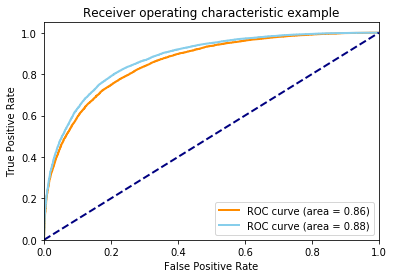

For Test
[[7897 2103]
 [2404 7596]]


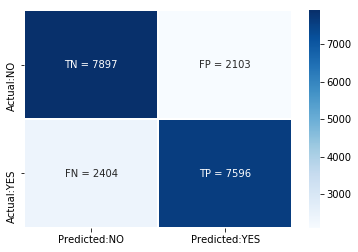

For Train
[[11979  3021]
 [ 3125 11875]]


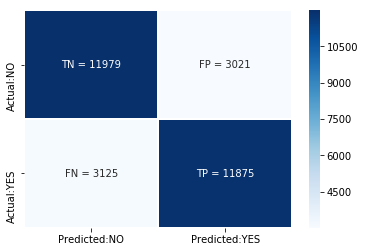

In [39]:
plt.figure()
lw = 2

#ROC_AUC curve
# plot for test

prob = model.predict_proba(X_test)
pred = []
for i in range (0,X_test.shape[0]):
    pred.append(prob[i][1]) 
fpr, tpr, thresholds = roc_curve(Y_test,pred)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

#plot for train

prob = model.predict_proba(X_train)
pred = []
for i in range (0,X_train.shape[0]):
    pred.append(prob[i][1]) 
fpr, tpr, thresholds = roc_curve(Y_train,pred)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='skyblue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
print('='*50)

#confusion_matrix
#test
print('For Test')
pred = model.predict(X_test)
CM = confusion_matrix(Y_test, pred)
A = ['TN','FP','FN','TP']
B= CM.ravel()
for i in range (0,4):
    A[i] = '%s = %d' %(A[i],B[i])
A =np.array(A).reshape((2,2))
print(CM)
heatmap(CM,cmap="Blues",linewidths=.5,annot = A,fmt ='s',yticklabels=['Actual:NO','Actual:YES'],xticklabels=['Predicted:NO','Predicted:YES'])
plt.show()
#train
print('For Train')
pred = model.predict(X_train)
CM = confusion_matrix(Y_train, pred)
A = ['TN','FP','FN','TP']
B= CM.ravel()
for i in range (0,4):
    A[i] = '%s = %d' %(A[i],B[i])
A =np.array(A).reshape((2,2))
print(CM)
heatmap(CM,cmap="Blues",linewidths=.5,annot = A,fmt ='s',yticklabels=['Actual:NO','Actual:YES'],xticklabels=['Predicted:NO','Predicted:YES'])
plt.show()

### TF-IDF W2V

In [43]:
#pkl = open('/content/driver/My Drive/tf_w2v_train.pkl','rb') 
#TF_W2V_train = pickle.load(pkl)
#pkl.close()

#pkl = open('/content/driver/My Drive/tf_w2v_test.pkl','rb') 
#TF_W2V_test = pickle.load(pkl)
#pkl.close()

In [44]:
scaler = preprocessing.StandardScaler().fit(TF_W2V_train)
X_train = scaler.transform(TF_W2V_train)
X_test = scaler.transform(TF_W2V_test)

In [45]:
now = datetime.now()
tuned_parameters = [{'max_depth': [1,2,3],'n_estimators':[20,50,75,100]}] #values of hyperparameter for tunning
clf = xgb.XGBClassifier() #define classifier
model = GridSearchCV(clf, tuned_parameters, scoring = 'roc_auc', cv=3, return_train_score=True) #cross validation
model.fit(X_train, Y_train)

print(model.best_estimator_)
print(model.score(X_test, Y_test))
results =model.cv_results_

tfw2v_model = model
print(datetime.now() - now)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)
0.82687526
0:03:47.367147


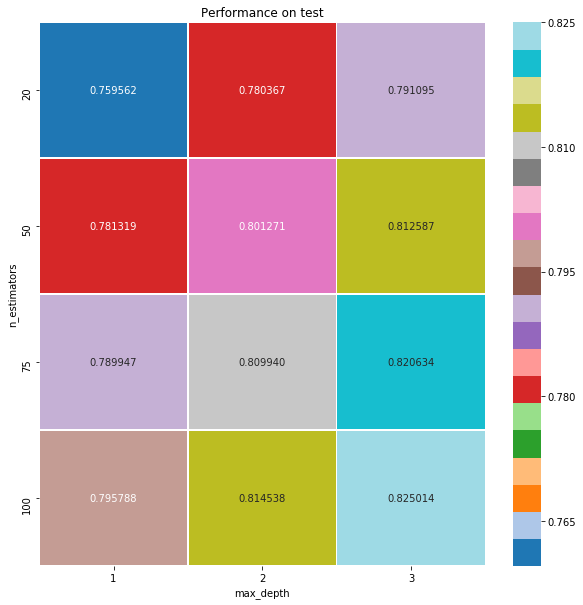

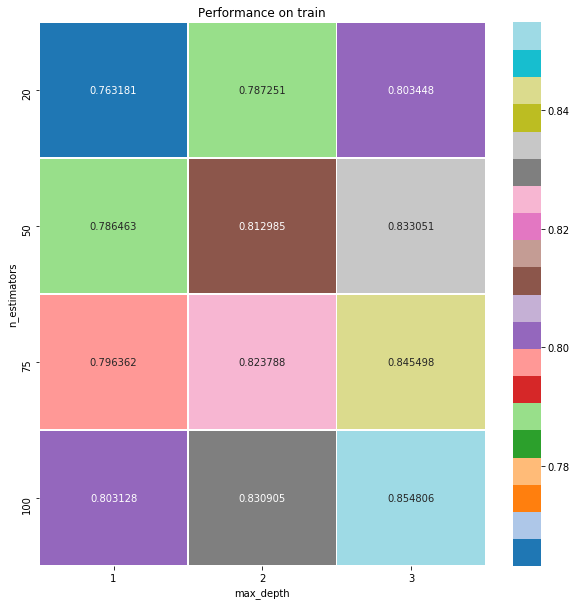

In [46]:
AUC_train = model.cv_results_['mean_train_score'].reshape((3,4)).T
AUC_test = model.cv_results_['mean_test_score'].reshape((3,4)).T
plt.figure(figsize=(10,10))
heatmap(AUC_test,cmap="tab20",linewidths=.5,annot = AUC_test,fmt ='f',xticklabels=[1,2,3],yticklabels=[20,50,75,100])
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.title("Performance on test")
plt.show()
plt.figure(figsize=(10,10))
heatmap(AUC_train,cmap="tab20",linewidths=.5,annot = AUC_train,fmt ='f',xticklabels=[1,2,3],yticklabels=[20,50,75,100])
plt.xlabel("max_depth")
plt.ylabel("n_estimators")
plt.title("Performance on train")
plt.show()

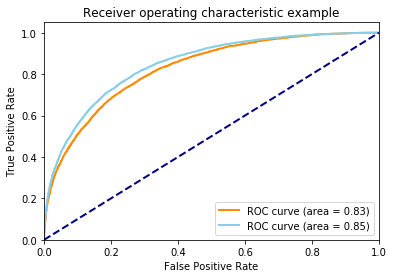

For Test
[[7519 2481]
 [2636 7364]]


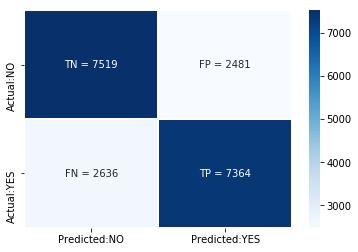

For Train
[[11477  3523]
 [ 3557 11443]]


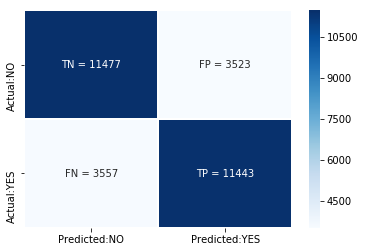

In [47]:
plt.figure()
lw = 2

#ROC_AUC curve
# plot for test

prob = model.predict_proba(X_test)
pred = []
for i in range (0,X_test.shape[0]):
    pred.append(prob[i][1]) 
fpr, tpr, thresholds = roc_curve(Y_test,pred)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

#plot for train

prob = model.predict_proba(X_train)
pred = []
for i in range (0,X_train.shape[0]):
    pred.append(prob[i][1]) 
fpr, tpr, thresholds = roc_curve(Y_train,pred)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, color='skyblue',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
print('='*50)

#confusion_matrix
#test
print('For Test')
pred = model.predict(X_test)
CM = confusion_matrix(Y_test, pred)
A = ['TN','FP','FN','TP']
B= CM.ravel()
for i in range (0,4):
    A[i] = '%s = %d' %(A[i],B[i])
A =np.array(A).reshape((2,2))
print(CM)
heatmap(CM,cmap="Blues",linewidths=.5,annot = A,fmt ='s',yticklabels=['Actual:NO','Actual:YES'],xticklabels=['Predicted:NO','Predicted:YES'])
plt.show()
#train
print('For Train')
pred = model.predict(X_train)
CM = confusion_matrix(Y_train, pred)
A = ['TN','FP','FN','TP']
B= CM.ravel()
for i in range (0,4):
    A[i] = '%s = %d' %(A[i],B[i])
A =np.array(A).reshape((2,2))
print(CM)
heatmap(CM,cmap="Blues",linewidths=.5,annot = A,fmt ='s',yticklabels=['Actual:NO','Actual:YES'],xticklabels=['Predicted:NO','Predicted:YES'])
plt.show()

## Summary

In [40]:
x = PrettyTable()
x.field_names = ["Model","Vectors","score"]
x.add_row(["Lexicon rule based analysis model","--",0.8541])
x.add_row(["XGBClassifier","BOW",0.8989 ])
x.add_row(["XGBClassifier","TFIDF",0.8994])
x.add_row(["XGBClassifier","AVG W2V", 0.8588])
x.add_row(["XGBClassifier","TFIDF W2v", 0.8269])
print('Values of Hyper parameters')
print(x)

Values of Hyper parameters
+-----------------------------------+-----------+--------+
|               Model               |  Vectors  | score  |
+-----------------------------------+-----------+--------+
| Lexicon rule based analysis model |     --    | 0.8541 |
|           XGBClassifier           |    BOW    | 0.8989 |
|           XGBClassifier           |   TFIDF   | 0.8994 |
|           XGBClassifier           |  AVG W2V  | 0.8588 |
|           XGBClassifier           | TFIDF W2v | 0.8269 |
+-----------------------------------+-----------+--------+


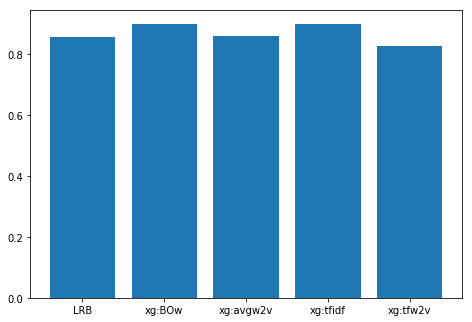

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['LRB', 'xg:BOw', 'xg:tfidf', 'xg:avgw2v', 'xg:tfw2v']
students = [0.8541,0.8989,0.8994 ,0.8588,0.8269]
ax.bar(langs,students)
plt.show()